# Lecture 10 Demonstration

In this demonstration, we define a few simple neural networks and train them on a simple one dimensional dataset.

In addition to understanding the core training loop of neural networks, we're going to focus on understanding a few things:
1. What kinds of functions does a MLP learn?
2. How does this depend on activation functions?
3. How does this depend on number of hidden nodes and depth?


In [1]:
import torch
from torch import nn
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split

np.random.seed(100)
torch.manual_seed(100)

In [2]:
def noiseless(x1, x2):
    radius = np.sqrt(np.power(x1, 2) + np.power(x2, 2))
    return 20 * np.cos(radius) * np.exp(-radius / 8)

def dgp(n):
    x1 = np.random.uniform(low=-5, high=5, size = n)
    x2 = np.random.uniform(low=-5, high=5, size = n)
    y = noiseless(x1, x2) + np.random.normal(scale = 1, size = n)
    return np.hstack((x1.reshape(-1, 1), x2.reshape(-1, 1))), y

In [3]:
n_grid = 1000
x1_grid = np.linspace(-5, 5, n_grid)
x2_grid = np.linspace(-5, 5, n_grid)
X, Y = np.meshgrid(x1_grid, x2_grid)

X_grid = np.c_[X.ravel(), Y.ravel()]
X1_grid = np.hstack((x1_grid.reshape(-1,1), np.zeros((n_grid, 1))))

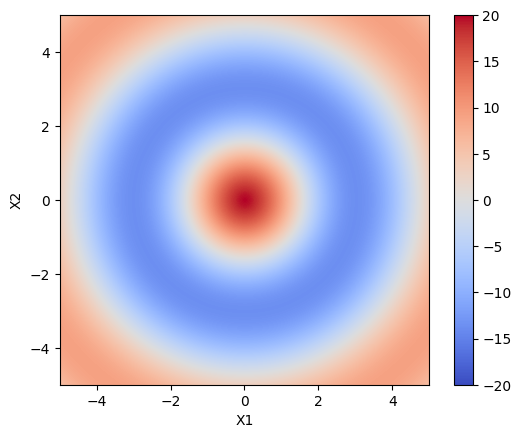

In [4]:
Z = noiseless(X, Y)

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [5]:
X, y = dgp(n = 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X_train = torch.from_numpy(X_train).to(torch.float)
y_train = torch.from_numpy(y_train).to(torch.float)
X_test = torch.from_numpy(X_test).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)

train = data_utils.TensorDataset(X_train, y_train)
test = data_utils.TensorDataset(X_test, y_test)

X_grid = torch.from_numpy(X_grid).to(torch.float)
X1_grid = torch.from_numpy(X1_grid).to(torch.float)

In [6]:
def nonlinearity_constructor(name):
    if (name == "relu"):
        return nn.ReLU()
    if (name == "sigmoid"):
        return nn.Sigmoid()
    if (name == "leakyrelu"):
        return nn.LeakyReLU()
    raise ValueError("Unknown nonlinearity!")

class SimpleMLP(nn.Module):
    def __init__(self, num_input = 2, num_hidden = 10, num_output = 1, nonlinearity = "relu"):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(num_input, num_hidden),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(num_hidden, num_output)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [7]:
model = SimpleMLP()
print(model)

SimpleMLP(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [8]:
{k:v.shape for k,v in dict(model.named_parameters()).items()}

{'layer_stack.0.weight': torch.Size([10, 2]),
 'layer_stack.0.bias': torch.Size([10]),
 'layer_stack.2.weight': torch.Size([1, 10]),
 'layer_stack.2.bias': torch.Size([1])}

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), max_iter = 1000, line_search_fn = "strong_wolfe")

def closure():
    model.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred.flatten(), y_train)
    loss.backward()
    return loss

optimizer.step(closure)

tensor(77.7388, grad_fn=<MseLossBackward0>)

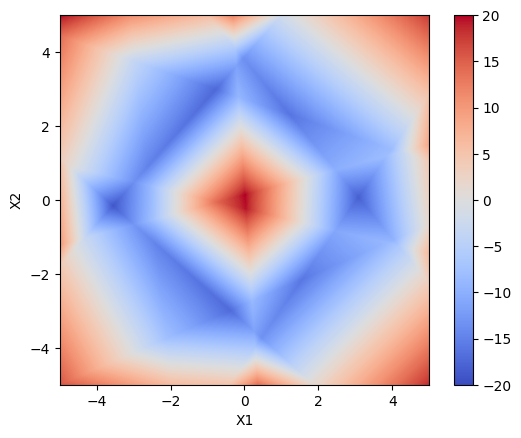

In [10]:
Z = model(X_grid)
Z = Z.detach().numpy().reshape((n_grid, n_grid))

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

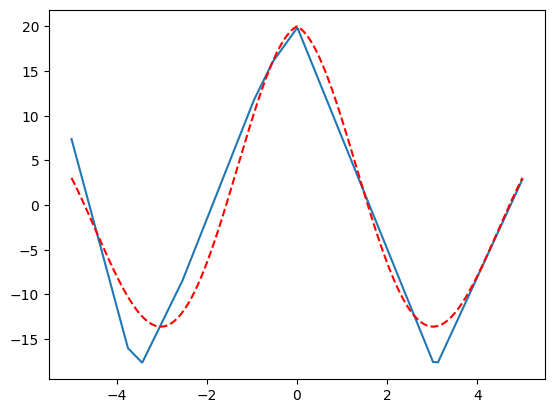

In [11]:
pred = model(X1_grid)

plt.plot(X1_grid.numpy()[:,0], pred.detach().numpy(), '-')
plt.plot(X1_grid.numpy()[:,0], noiseless(X1_grid.numpy()[:,0], X1_grid.numpy()[:,1]), '--', color="red");

In [12]:
model = SimpleMLP(nonlinearity="sigmoid")
print(model)

SimpleMLP(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


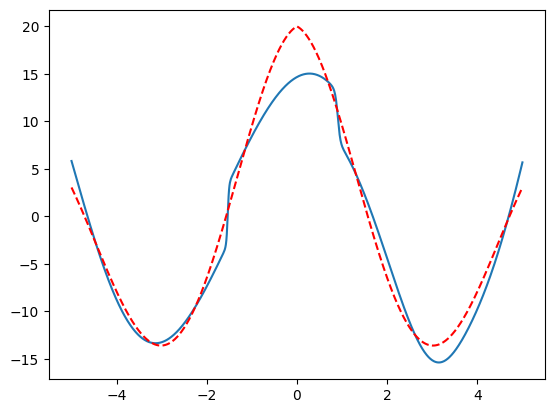

In [13]:
optimizer = torch.optim.LBFGS(model.parameters(), max_iter = 1000, line_search_fn = "strong_wolfe")
optimizer.step(closure)

pred = model(X1_grid)

plt.plot(X1_grid.numpy()[:,0], pred.detach().numpy(), '-')
plt.plot(X1_grid.numpy()[:,0], noiseless(X1_grid.numpy()[:,0], X1_grid.numpy()[:,1]), '--', color="red");

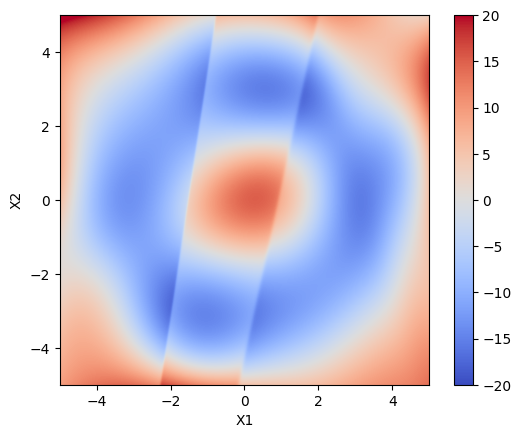

In [14]:
Z = model(X_grid)
Z = Z.detach().numpy().reshape((n_grid, n_grid))

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [15]:
model = SimpleMLP(num_hidden = 100)
optimizer = torch.optim.LBFGS(model.parameters(), max_iter = 1000, line_search_fn = "strong_wolfe")
print(model)

SimpleMLP(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [16]:
optimizer.step(closure)

tensor(77.1058, grad_fn=<MseLossBackward0>)

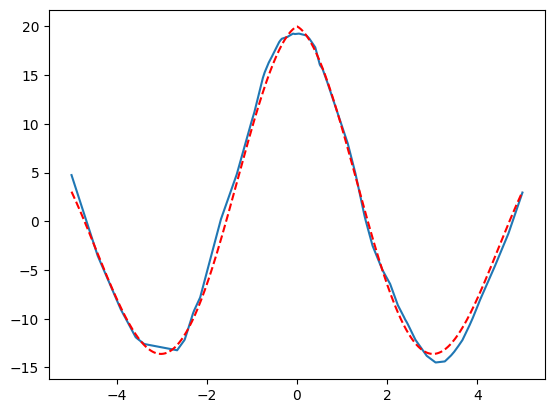

In [17]:
pred = model(X1_grid)

plt.plot(X1_grid.numpy()[:,0], pred.detach().numpy(), '-')
plt.plot(X1_grid.numpy()[:,0], noiseless(X1_grid.numpy()[:,0], X1_grid.numpy()[:,1]), '--', color="red");

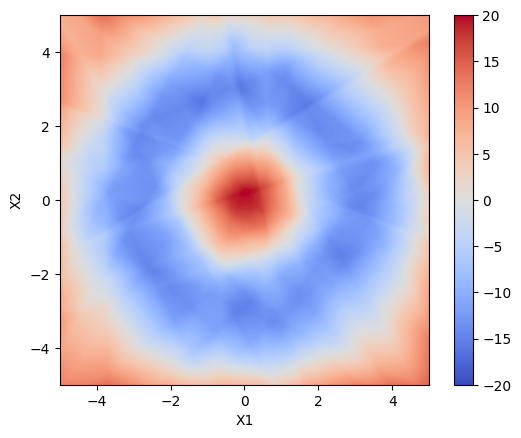

In [18]:
Z = model(X_grid)
Z = Z.detach().numpy().reshape((n_grid, n_grid))

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [19]:
def train_model(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.flatten(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_model(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y).item()
    test_loss /= num_batches
    print(f"Avg test loss: {test_loss:>8f} \n")
    return test_loss

In [20]:
model = SimpleMLP(num_hidden = 10)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-2, weight_decay=1e-6)

train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size=64, shuffle=True)

epochs = 500
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_loader, model, loss_fn, optimizer)
    test_loss.append(test_model(test_loader, model, loss_fn))

mlp10 = test_loss[-1]

Epoch 1
-------------------------------
loss: 94.508598  [   64/  700]
loss: 82.054871  [  384/  700]
loss: 83.910667  [  660/  700]
Avg test loss: 76.727232 

Epoch 2
-------------------------------
loss: 73.299347  [   64/  700]
loss: 61.985603  [  384/  700]
loss: 79.511398  [  660/  700]
Avg test loss: 75.448012 

Epoch 3
-------------------------------
loss: 62.771759  [   64/  700]
loss: 82.357491  [  384/  700]
loss: 87.750214  [  660/  700]
Avg test loss: 77.504337 

Epoch 4
-------------------------------
loss: 78.018211  [   64/  700]
loss: 81.969254  [  384/  700]
loss: 68.153534  [  660/  700]
Avg test loss: 74.221207 

Epoch 5
-------------------------------
loss: 80.508621  [   64/  700]
loss: 67.779106  [  384/  700]
loss: 72.888817  [  660/  700]
Avg test loss: 72.401128 

Epoch 6
-------------------------------
loss: 58.697571  [   64/  700]
loss: 92.065895  [  384/  700]
loss: 59.099072  [  660/  700]
Avg test loss: 69.604424 

Epoch 7
-------------------------------


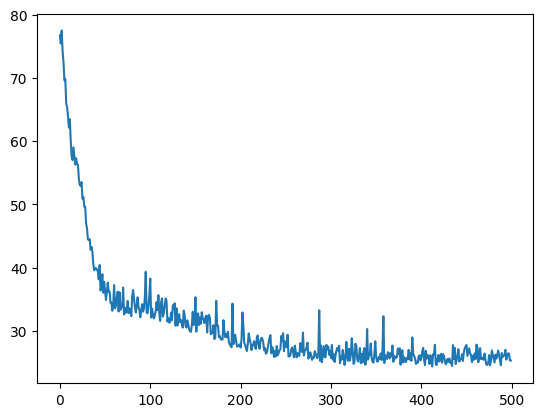

In [21]:
plt.plot(test_loss, '-');

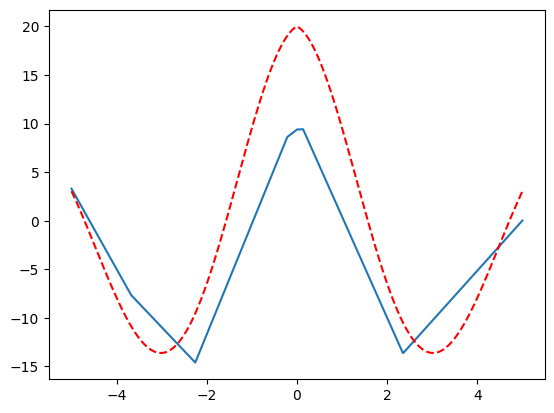

In [22]:
pred = model(X1_grid)

plt.plot(X1_grid.numpy()[:,0], pred.detach().numpy(), '-')
plt.plot(X1_grid.numpy()[:,0], noiseless(X1_grid.numpy()[:,0], X1_grid.numpy()[:,1]), '--', color="red");

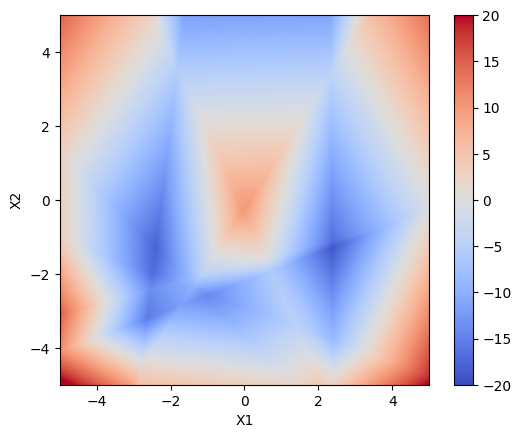

In [23]:
Z = model(X_grid)
Z = Z.detach().numpy().reshape((n_grid, n_grid))

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [24]:
model = SimpleMLP(num_hidden = 100)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-2, weight_decay=1e-6)

epochs = 500
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_loader, model, loss_fn, optimizer)
    test_loss.append(test_model(test_loader, model, loss_fn))

mlp100 = test_loss[-1]

Epoch 1
-------------------------------
loss: 70.012314  [   64/  700]
loss: 70.784943  [  384/  700]
loss: 63.938572  [  660/  700]
Avg test loss: 73.372664 

Epoch 2
-------------------------------
loss: 83.246399  [   64/  700]
loss: 63.617584  [  384/  700]
loss: 62.734501  [  660/  700]
Avg test loss: 70.777149 

Epoch 3
-------------------------------
loss: 73.043167  [   64/  700]
loss: 60.338074  [  384/  700]
loss: 66.370598  [  660/  700]
Avg test loss: 62.424511 

Epoch 4
-------------------------------
loss: 49.190968  [   64/  700]
loss: 62.993896  [  384/  700]
loss: 50.435600  [  660/  700]
Avg test loss: 57.823370 

Epoch 5
-------------------------------
loss: 54.375278  [   64/  700]
loss: 70.890465  [  384/  700]
loss: 48.834293  [  660/  700]
Avg test loss: 54.567756 

Epoch 6
-------------------------------
loss: 40.716927  [   64/  700]
loss: 65.245255  [  384/  700]
loss: 39.248547  [  660/  700]
Avg test loss: 46.805939 

Epoch 7
-------------------------------


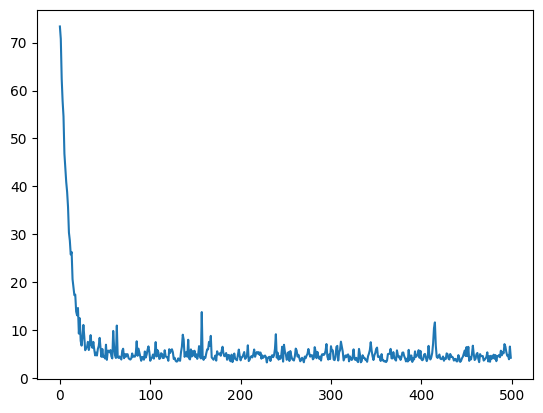

In [25]:
plt.plot(test_loss, '-');

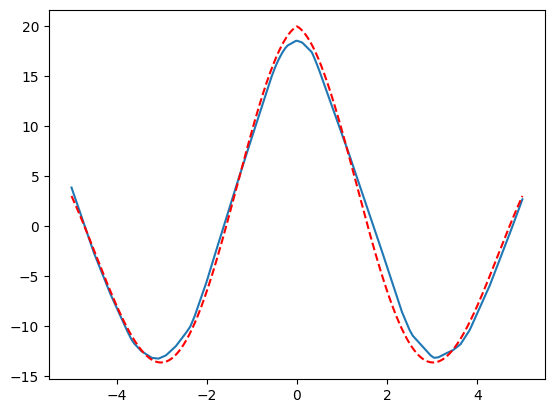

In [26]:
pred = model(X1_grid)

plt.plot(X1_grid.numpy()[:,0], pred.detach().numpy(), '-')
plt.plot(X1_grid.numpy()[:,0], noiseless(X1_grid.numpy()[:,0], X1_grid.numpy()[:,1]), '--', color="red");

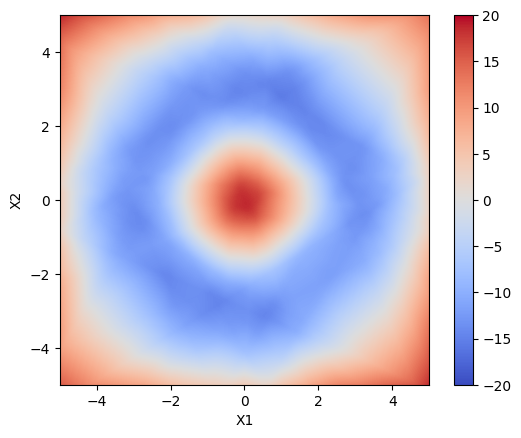

In [27]:
Z = model(X_grid)
Z = Z.detach().numpy().reshape((n_grid, n_grid))

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

Epoch 1
-------------------------------
loss: 71.610466  [   64/  700]
loss: 138.164276  [  384/  700]
loss: 64.198624  [  660/  700]
Avg test loss: 101.971637 

Epoch 2
-------------------------------
loss: 73.922981  [   64/  700]
loss: 72.748894  [  384/  700]
loss: 75.919472  [  660/  700]
Avg test loss: 66.358479 

Epoch 3
-------------------------------
loss: 68.914413  [   64/  700]
loss: 81.845146  [  384/  700]
loss: 69.337433  [  660/  700]
Avg test loss: 63.122152 

Epoch 4
-------------------------------
loss: 64.520683  [   64/  700]
loss: 58.095535  [  384/  700]
loss: 44.221779  [  660/  700]
Avg test loss: 46.270894 

Epoch 5
-------------------------------
loss: 58.226273  [   64/  700]
loss: 43.426105  [  384/  700]
loss: 53.275234  [  660/  700]
Avg test loss: 42.764606 

Epoch 6
-------------------------------
loss: 28.487659  [   64/  700]
loss: 38.291470  [  384/  700]
loss: 31.515165  [  660/  700]
Avg test loss: 36.753258 

Epoch 7
------------------------------

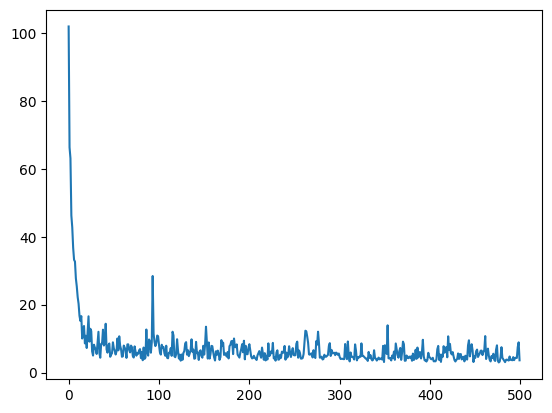

In [28]:
model = SimpleMLP(num_hidden = 1000)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-2, weight_decay=1e-6)

epochs = 500
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_loader, model, loss_fn, optimizer)
    test_loss.append(test_model(test_loader, model, loss_fn))
plt.plot(test_loss, '-')

mlp1000 = test_loss[-1]

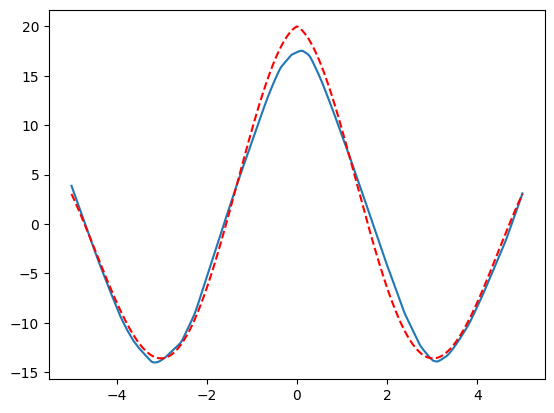

In [29]:
pred = model(X1_grid)

plt.plot(X1_grid.numpy()[:,0], pred.detach().numpy(), '-')
plt.plot(X1_grid.numpy()[:,0], noiseless(X1_grid.numpy()[:,0], X1_grid.numpy()[:,1]), '--', color="red");

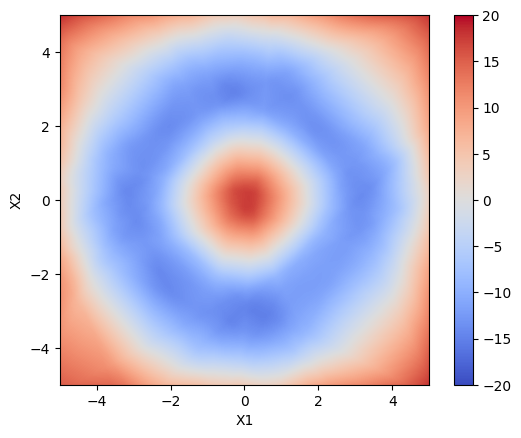

In [30]:
Z = model(X_grid)
Z = Z.detach().numpy().reshape((n_grid, n_grid))

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [31]:
class DeeperMLP(nn.Module):
    def __init__(self, num_input = 2, num_hidden = 10, num_output = 1, nonlinearity = "relu"):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(num_input, num_hidden),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(num_hidden, num_hidden),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(num_hidden, num_hidden),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(num_hidden, num_output)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [32]:
model = DeeperMLP(num_hidden = 10)
print(model)

DeeperMLP(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [33]:
{k:np.prod(v.shape) for k,v in dict(model.named_parameters()).items()}

{'layer_stack.0.weight': 20,
 'layer_stack.0.bias': 10,
 'layer_stack.2.weight': 100,
 'layer_stack.2.bias': 10,
 'layer_stack.4.weight': 100,
 'layer_stack.4.bias': 10,
 'layer_stack.6.weight': 10,
 'layer_stack.6.bias': 1}

Epoch 1
-------------------------------
loss: 92.273026  [   64/  700]
loss: 79.973801  [  384/  700]
loss: 82.327393  [  660/  700]
Avg test loss: 75.245367 

Epoch 2
-------------------------------
loss: 54.702164  [   64/  700]
loss: 55.297890  [  384/  700]
loss: 74.510941  [  660/  700]
Avg test loss: 61.066357 

Epoch 3
-------------------------------
loss: 54.052635  [   64/  700]
loss: 55.902748  [  384/  700]
loss: 60.304966  [  660/  700]
Avg test loss: 51.581344 

Epoch 4
-------------------------------
loss: 62.835865  [   64/  700]
loss: 62.733437  [  384/  700]
loss: 28.648163  [  660/  700]
Avg test loss: 48.568382 

Epoch 5
-------------------------------
loss: 52.545013  [   64/  700]
loss: 42.793999  [  384/  700]
loss: 35.489246  [  660/  700]
Avg test loss: 41.638206 

Epoch 6
-------------------------------
loss: 42.842636  [   64/  700]
loss: 32.680939  [  384/  700]
loss: 39.619743  [  660/  700]
Avg test loss: 37.042989 

Epoch 7
-------------------------------


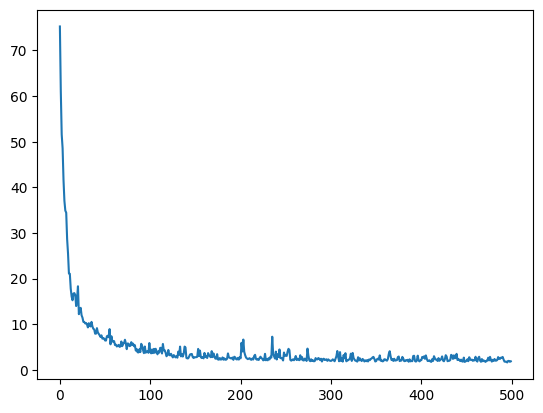

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2, weight_decay=1e-6)

epochs = 500
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_loader, model, loss_fn, optimizer)
    test_loss.append(test_model(test_loader, model, loss_fn))
plt.plot(test_loss, '-')

mlpdeep = test_loss[-1]

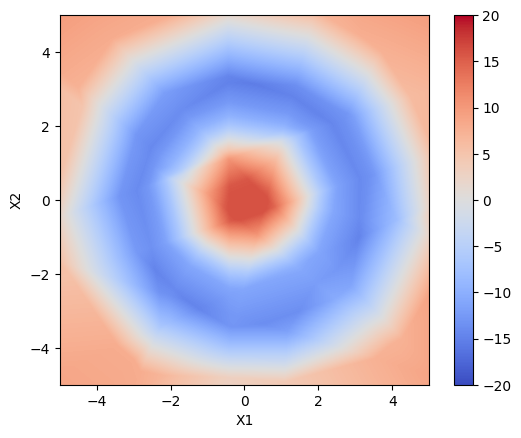

In [35]:
Z = model(X_grid)
Z = Z.detach().numpy().reshape((n_grid, n_grid))

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [36]:
print("The test error of the models:")
print(f"MLP (1 hidden layer, 10 hidden nodes): {mlp10:0.4f}")
print(f"MLP (1 hidden layer, 100 hidden nodes): {mlp100:0.4f}")
print(f"MLP (1 hidden layer, 1000 hidden nodes): {mlp1000:0.4f}")
print(f"MLP (3 hidden layers, 10 hidden nodes): {mlpdeep:0.4f}")

The test error of the models:
MLP (1 hidden layer, 10 hidden nodes): 25.3098
MLP (1 hidden layer, 100 hidden nodes): 4.1878
MLP (1 hidden layer, 1000 hidden nodes): 3.5984
MLP (3 hidden layers, 10 hidden nodes): 1.8649


In [37]:
def train_model(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred[:,0].flatten(), y, torch.abs(pred[:,1]).flatten())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_model(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred[:,0].flatten(), y, torch.abs(pred[:,1]).flatten()).item()
    test_loss /= num_batches
    print(f"Avg test loss: {test_loss:>8f} \n")
    return test_loss

Epoch 1
-------------------------------
loss: 195.810822  [   64/  700]
loss: 9.159243  [  384/  700]
loss: 8.409966  [  660/  700]
Avg test loss: 6.778708 

Epoch 2
-------------------------------
loss: 7.403884  [   64/  700]
loss: 6.061344  [  384/  700]
loss: 4.371561  [  660/  700]
Avg test loss: 3.826368 

Epoch 3
-------------------------------
loss: 4.042647  [   64/  700]
loss: 3.668822  [  384/  700]
loss: 3.646842  [  660/  700]
Avg test loss: 3.670029 

Epoch 4
-------------------------------
loss: 3.796498  [   64/  700]
loss: 3.539921  [  384/  700]
loss: 3.212600  [  660/  700]
Avg test loss: 3.062172 

Epoch 5
-------------------------------
loss: 3.053065  [   64/  700]
loss: 2.973018  [  384/  700]
loss: 2.868165  [  660/  700]
Avg test loss: 2.855099 

Epoch 6
-------------------------------
loss: 2.940341  [   64/  700]
loss: 2.907938  [  384/  700]
loss: 2.738399  [  660/  700]
Avg test loss: 2.825956 

Epoch 7
-------------------------------
loss: 2.863440  [   64

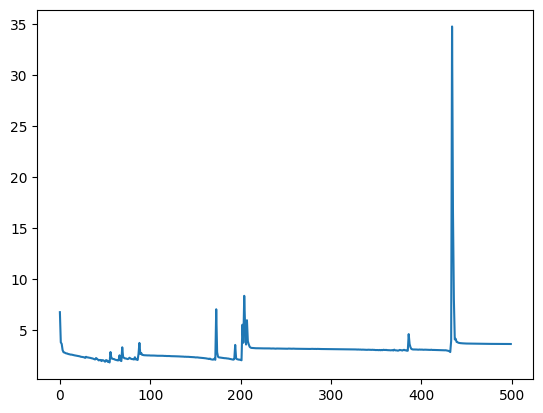

In [38]:
model = SimpleMLP(num_hidden = 1000, num_output=2)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-2, weight_decay=1e-6)

nll_loss = nn.GaussianNLLLoss()

epochs = 500
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_loader, model, nll_loss, optimizer)
    test_loss.append(test_model(test_loader, model, nll_loss))
plt.plot(test_loss, '-')

mlp1000 = test_loss[-1]

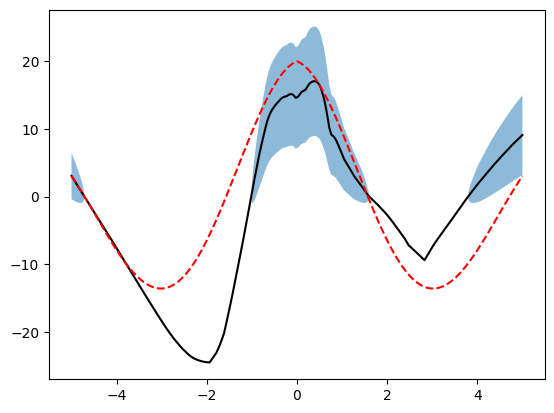

In [39]:
pred = model(X1_grid)

mu = pred[:, 0].detach().numpy()
se = torch.sqrt(pred[:, 0]).detach().numpy()

plt.plot(X1_grid.numpy()[:,0], mu, '-', color = "black")
plt.fill_between(X1_grid.numpy()[:,0], mu - 1.96 * se, mu + 1.96 * se, alpha = 0.5)
plt.plot(X1_grid.numpy()[:,0], noiseless(X1_grid.numpy()[:,0], X1_grid.numpy()[:,1]), '--', color="red");

You may want to also read some materials like Andrej Karpathy's classic 2019 blogpost with a lot of practical wisdom: https://karpathy.github.io/2019/04/25/recipe/